In [56]:
import numpy as np
from skimage import *
from scipy.ndimage import map_coordinates
from scipy.signal import find_peaks
from matplotlib import pyplot as plt
from skimage.metrics import structural_similarity as ssim
import matplotlib.gridspec as gridspec
from datetime import datetime
from skimage.feature import match_template
from tkinter import Tk  # from tkinter import Tk for Python 3.x
from tkinter import messagebox
from tkinter.filedialog import askdirectory
#from skimage.external import tifffile
import os, sys
import matplotlib.gridspec as gridspec
from scipy.interpolate import interp1d
import xml.etree.ElementTree as ET
import cv2
import matplotlib.image as mpimg
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from skimage.measure import profile_line
from scipy.optimize import curve_fit

In [57]:
import os

directory = "../Images"

files = os.listdir(directory)

list_image_to_process = []

for file in files:
    if os.path.isdir(directory + "/" + file):  # Check if the item is a directory
        imgs = os.listdir(directory + "/" + file)
        for img in imgs:
            if img.endswith(".tif") and "16" in img:
                list_image_to_process.append(directory + "/" + file + "/" + img)

print(list_image_to_process)
len(list_image_to_process)

['../Images/20221104_Controle_Periodique_OUN/16-200-IQI_TrouFondPlat_04-11-2022.tif', '../Images/20221104_Controle_Periodique_OUN/16-IQI_TrouFondPlat_04-11-2022.tif', '../Images/20230502_Controle_Periodique_DAN/16-200-IQI_TrouFondPlat_02-05-2023.tif', '../Images/20230502_Controle_Periodique_DAN/16-IQI_TrouFondPlat_02-05-2023.tif', '../Images/20240201_Controle_Periodique_DAN/16-200-IQI_TrouFondPlat_01-02-2024.tif', '../Images/20240201_Controle_Periodique_DAN/16-IQI_TrouFondPlat_01-02-2024.tif', '../Images/Résolution3/16-200-IQI_TrouFondPlat_02-01-2023.tif', '../Images/Résolution3/16-200-IQI_TrouFondPlat_02-05-2023.tif', '../Images/Résolution3/16-200-IQI_TrouFondPlat_03-01-2023.tif', '../Images/Résolution3/16-200-IQI_TrouFondPlat_03-04-2023.tif', '../Images/Résolution3/16-200-IQI_TrouFondPlat_03-07-2023.tif', '../Images/Résolution3/16-200-IQI_TrouFondPlat_03-08-2023.tif', '../Images/Résolution3/16-200-IQI_TrouFondPlat_04-12-2023.tif', '../Images/Résolution3/16-200-IQI_TrouFondPlat_05-12-

50

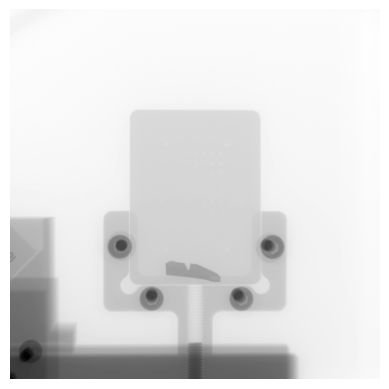

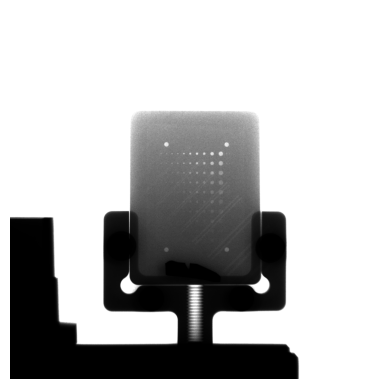

In [58]:
images = []
cropped_images = []
image_initial = []
path_inter =[]

 # 4 marche perefect
#marche: 1,2,3,5
#marche pas: 0,6
for path in list_image_to_process:
    # Vérifier si le nom du fichier commence par "16"
    if '03-08-2023' in path:  # '03-08-2023' perfect
        path_inter.append(path)
        # Charger l'image et changer le contraste
        image = mpimg.imread(path)
        # Adaptation 16bits -> 8bits
        image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        image_initial.append(image)
        # Ajustement du contraste et luminosité
        brightness_factor = 1.16
        brightened_image = image * brightness_factor

        # S'assurer que les valeurs sont toujours dans l'intervalle [0, 1]
        brightened_image = np.clip(brightened_image, 0, 255)
        image_contraste = exposure.adjust_gamma(brightened_image,30)

        images.append(image_contraste)


        # Afficher l'image recadrée
plt.imshow(image_initial[1], cmap='gray')
plt.axis('off')
        #plt.t0tle(f'Image recadrée: {path}')
plt.show()
        # Afficher l'image recadrée
plt.imshow(images[1], cmap='gray')
plt.axis('off')
        #plt.title(f'Image recadrée: {path}')
plt.show()

In [59]:
len(images)

2

In [60]:
def load_image(image_path):
    """
    Charge une image en niveau de gris
    :param image_path: chemin de l'image
    :return: image en niveau de gris
    """
    image = mpimg.imread(image_path, cv2.IMREAD_GRAYSCALE)
    return image

def template_matching(template1_path, template2_path, image):
    """
    Trouver le meilleur match entre le template et l'image
    :param template1: template 1
    :param template2: template 2
    :param image: image
    :return: coordonnées du meilleur match
    """
    template1 = load_image(template1_path)
    template2 = load_image(template2_path)

    template1 =cv2.cvtColor(template1, cv2.COLOR_BGR2GRAY)
    template2 =cv2.cvtColor(template2, cv2.COLOR_BGR2GRAY)

    ################# Template 1 #####################
    liste_temp_match1 = []
    result = match_template(image, template1)

    # Trouver l'emplacement maximal de la correspondance
    ij = np.unravel_index(np.argmax(result), result.shape)
    x, y = ij[::-1]
    h, w = template1.shape
    """
    # Dessiner un rectangle autour de la zone correspondante
    
    fig, ax = plt.subplots(1, figsize=(5, 5))
    ax.imshow(image, cmap='gray')
    rect = plt.Rectangle((x, y), w, h, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    plt.title('Detected Template')
    plt.show()
    """
    # Croper l'image selon le template matching
    cropped_image1 = image[y:y+h, x:x+w]

    # Ajouter l'image croppée à la liste
    liste_temp_match1.append(cropped_image1)

    '''
    # Afficher l'image croppée pour vérification
    plt.figure(figsize=(5, 5))
    plt.imshow(cropped_image1, cmap='gray')
    plt.title('Cropped Image 1')
    plt.show()
    '''

    ################## Template 2 ######################
    liste_temp_match2 = []
    # Appliquer le template matching
    result = match_template(cropped_image1, template2)

    # Trouver l'emplacement maximal de la correspondance
    ij = np.unravel_index(np.argmax(result), result.shape)
    x, y = ij[::-1]
    h, w = template2.shape

    '''
    # Dessiner un rectangle autour de la zone correspondante
    fig, ax = plt.subplots(1, figsize=(5, 5))
    ax.imshow(cropped_image1, cmap='gray')
    rect = plt.Rectangle((x, y), w, h, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    plt.title('Detected Template')
    plt.show()
    '''
    # Croper l'image selon le template matching
    cropped_image2 = cropped_image1[y:y+h, x:x+w]

    # Ajouter l'image croppée à la liste
    liste_temp_match2.append(cropped_image2)

    # Afficher l'image croppée pour vérification
    '''
    plt.figure(figsize=(5, 5))
    plt.imshow(cropped_image2, cmap='gray')
    plt.title('Cropped Image 2')
    plt.show()
    '''
    return cropped_image2

TEMPLATE1_PATH = "template5.jpg"
TEMPLATE2_PATH = "template5bis.jpg"

def normalize_img(img):
    """
    Normaliser une image
    :param img: image à normaliser
    :return: image normalisée
    """
    min = np.min(img)
    max = np.max(img)

    normalized_image = (img - min) / (max - min) * 255
    normalized_image = np.uint8(normalized_image)
    # Supposons que  image soit stockée dans la variable "image"
    min_value = np.min(normalized_image)
    max_value = np.max(normalized_image)
    print(min_value)
    print(max_value)
    """
    plt.figure(figsize=(5, 5))
    plt.imshow(normalized_image, cmap='gray')
    plt.title('Normalized Image')
    plt.show()
    """
    return normalized_image

0
255


(-0.5, 518.5, 781.5, -0.5)

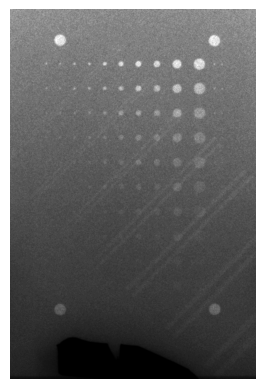

In [61]:
image = images[1]
image = normalize_img(image)
cropped_image = template_matching(TEMPLATE1_PATH, TEMPLATE2_PATH, image)
plt.imshow(cropped_image, cmap='gray')
plt.axis('off')
#plt.title('Cropped Image')

In [62]:
cropped_image.dtype

dtype('uint8')

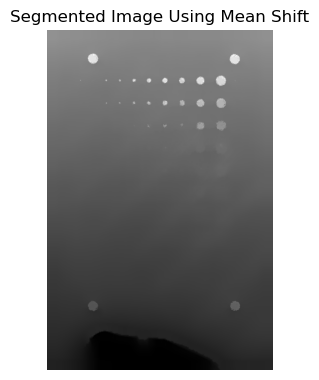

In [63]:
def mean_shift_segmentation(image):
    if image is None:
        print("Error: Image not found.")
        return

    # Convert from BGR to RGB for displaying
    original_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Define the criteria for stopping the algorithm
    # (type, max number of iterations, accuracy)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 500, 0.2)

    # Apply the Mean Shift algorithm to find the clusters
    segmented_image = cv2.pyrMeanShiftFiltering(original_image, sp=20, sr=40, maxLevel=1, termcrit=criteria)

    '''
    # Displaying the original and segmented images
    plt.figure(figsize=(15, 10))
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(original_image)
    plt.axis('off')
    '''
    plt.subplot(1, 2, 2)
    plt.title('Segmented Image Using Mean Shift')
    plt.imshow(segmented_image)
    plt.axis('off')
    plt.show()

    return segmented_image
# Provide the path to your image file
segmented_image_8 = mean_shift_segmentation(cropped_image)

img_2 = np.copy(cropped_image)

img_plot = np.copy(cropped_image)

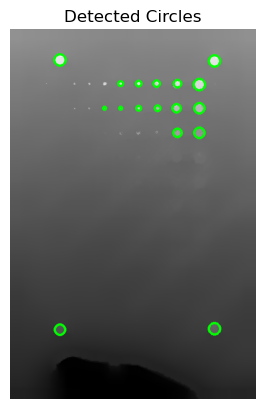

In [64]:
gray_img =  cv2.cvtColor(segmented_image_8, cv2.COLOR_BGR2GRAY)

# Check if image is loaded properly
if image is None:
    raise Exception("Error loading image")

# Apply Gaussian blur
blurred_gray_img = cv2.GaussianBlur(gray_img, (9, 9), 2)

# Detect circles using Hough Transform
circles = cv2.HoughCircles(blurred_gray_img, cv2.HOUGH_GRADIENT, dp=2, minDist=20,
                           param1=70, param2=20, minRadius=1, maxRadius=20 )

# Convert the original grayscale gray_img to BGR for visualization
output_gray_img = cv2.cvtColor(gray_img, cv2.COLOR_GRAY2BGR)

circle_centers = []

# Draw the circles
if circles is not None:
    circles = np.round(circles[0, :]).astype("int")
    for (x, y, r) in circles:
        cv2.circle(output_gray_img, (x, y), r, (0, 255, 0), 4)  # Draw in green
        circle_centers.append((x, y))

# Convert to RGB for displaying with Matplotlib
output_gray_img_rgb = cv2.cvtColor(output_gray_img, cv2.COLOR_BGR2RGB)

# Plotting the result
plt.imshow(output_gray_img_rgb)
plt.title('Detected Circles')
plt.axis('off')
plt.show()


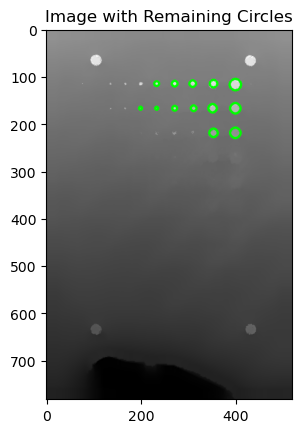

In [65]:
# Trouver la valeur minimale de y
if circles is not None:
    min_y = min([y for (x, y, r) in circles])

# Remove circles within ±10 pixels of the smallest y value and circles after y = 590
filtered_circles = []
for (x, y, r) in circles:
    if not (min_y - 10 <= y <= min_y + 10) and y < 590:
        filtered_circles.append((x, y, r))

# Convert the original grayscale image to BGR for visualization
output_image = cv2.cvtColor(gray_img, cv2.COLOR_GRAY2BGR)

# Draw the remaining circles
for (x, y, r) in filtered_circles:
    cv2.circle(output_image, (x, y), r, (0, 255, 0), 4)  # Draw in green

# Convert to RGB for displaying with Matplotlib
output_image_rgb = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)

circle_centers_filtered = []
for circle in filtered_circles:
    circle_centers_filtered.append((circle[0], circle[1]))
    
# Plotting the result
plt.imshow(output_image_rgb)
plt.title('Image with Remaining Circles')
plt.axis('on')
plt.show()


In [66]:
circle_centers_filtered

[(399, 117),
 (399, 219),
 (399, 167),
 (271, 115),
 (351, 167),
 (309, 115),
 (353, 115),
 (271, 167),
 (353, 219),
 (311, 167),
 (233, 167),
 (233, 115),
 (199, 167)]

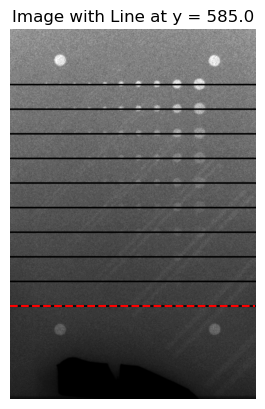

In [67]:
# Calculate distances between circle centers to determine the step
delta_y = []
for i in range(len(circle_centers_filtered)):
    for j in range(i +1, len(circle_centers_filtered)):
        (x1, y1) = circle_centers_filtered[i]
        (x2, y2) = circle_centers_filtered[j]
        distance_y = abs(y2 - y1)
        if 49 <= distance_y <= 60:
            delta_y.append(distance_y)

# Calculate the mean of delta_y to use as a step for drawing lines
mean_delta_y = np.median(delta_y) if delta_y else 0

# Draw 10 horizontal dashed lines starting from the y-coordinate of the first circle
if circle_centers_filtered:
    start_x, start_y = circle_centers_filtered[0]

    for i in range(10):
        y = start_y + i * mean_delta_y
        cv2.line(img_plot, (0, int(y)), (img_plot.shape[1], int(y)), (0, 0, 255), 2, lineType=cv2.LINE_AA)

    # Displaying the image with line
    plt.imshow(img_plot, cmap='gray')
    plt.axhline(y, color='r', linestyle='--')
    plt.title(f"Image with Line at y = {y}")
    plt.axis('off')
    plt.show()

Center X: 399, Center Y: 117
[130.         143.33333333 136.66666667 131.         130.
 124.33333333 113.         118.66666667 130.         124.33333333
 130.         130.         130.         124.33333333 130.
 130.         131.         143.33333333 130.         118.66666667
 130.         130.         118.66666667 113.         124.33333333
 130.         143.33333333 130.         130.         113.
 118.66666667 130.         124.33333333 124.33333333 113.
 113.         118.66666667 113.         118.66666667 118.66666667
 113.         113.         130.         130.         136.66666667
 124.33333333 118.66666667 124.33333333 124.33333333 124.33333333
 113.         113.         124.33333333 124.33333333 130.
 130.         118.66666667 124.33333333 113.         118.66666667
 118.66666667 124.33333333 130.         130.         124.33333333
 130.         130.         124.33333333 136.66666667 131.
 131.         124.33333333 136.66666667 130.         130.
 158.         150.66666667 150.666666

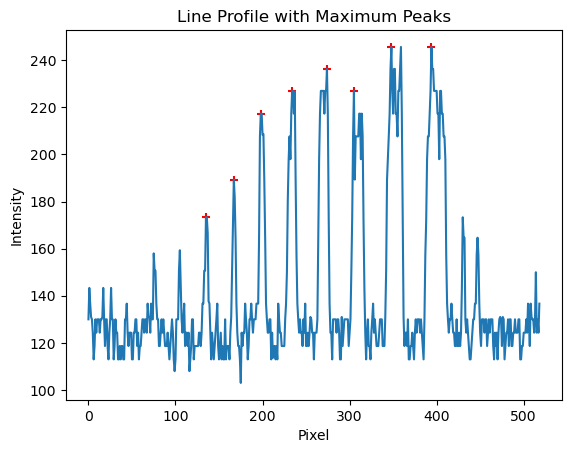

In [68]:
# Function to extract horizontal intensity profiles
def extract_horizontal_profile(image, y):
    """Extracts a horizontal intensity profile at the given y-coordinate."""
    profile = profile_line(image, (y, 0), (y, image.shape[1] - 1), linewidth=3, reduce_func=np.mean)
    #return image[y, :]
    return profile

def trouver_pics_maximaux(profil):
    # Trouver les pics maximaux avec une hauteur minimale de 0
    peaks, _ = find_peaks(profil, height=15, distance=15, prominence=15)

    # Trier les pics par valeur décroissante
    pics_valeurs = profil[peaks]
    pics_indices_tries = peaks[np.argsort(pics_valeurs)[::-1]]

    # Sélectionner les 10 premiers pics maximaux
    top_10_pics_indices = pics_indices_tries[:10]
    top_10_pics_valeurs = profil[top_10_pics_indices]

    return top_10_pics_indices, top_10_pics_valeurs

# Extract the center coordinates of the first circle
center_x, center_y, radius = filtered_circles[0]
print(f"Center X: {center_x}, Center Y: {center_y}")

center_y = int(center_y)
line_profile = extract_horizontal_profile(img_2, center_y)
print(line_profile)

# Detect maximum peaks using trouver_pics_maximaux
pics_maximaux_indices, pics_maximaux_valeurs = trouver_pics_maximaux(line_profile)

# Filter out indices that are less than the center x-coordinate
new_pics_maximum_index = [pic for pic in pics_maximaux_indices if pic < center_x]

# Print the indices and values of the maximum peaks
print("Indices of pics_maximaux:", new_pics_maximum_index)
print("Values of pics_maximaux:", [line_profile[index] for index in new_pics_maximum_index])

# Plotting
plt.plot(line_profile, label='Intensity Profile')
plt.scatter(new_pics_maximum_index, [line_profile[index] for index in new_pics_maximum_index], 
            color='red', marker='+', label='Pics Maximaux')
plt.title('Line Profile with Maximum Peaks')
plt.xlabel('Pixel')
plt.ylabel('Intensity')
#plt.legend()
plt.show()

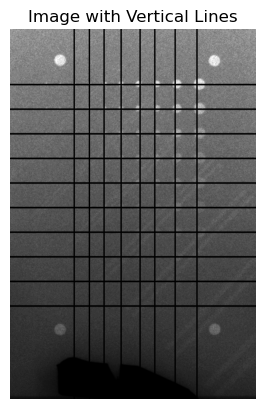

In [69]:
# Draw vertical lines passing through the vertical pic indices
for pic_index in new_pics_maximum_index:
    cv2.line(img_plot, (pic_index, 0), (pic_index, img_plot.shape[0]), (0, 0, 255), 2)

# Display the image with vertical lines
plt.imshow(img_plot, cmap='gray')
plt.title('Image with Vertical Lines')
plt.axis('off')
plt.show()


Delta X: [48, 48, 48, 46, 46, 46, 46, 46, 46, 44, 44, 42, 42, 42, 40, 40, 40, 38, 38, 38, 38, 38, 38, 34, 34]
Step: 47.16461538461539
Step: 45.44307692307693
Step: 43.72153846153847
Step: 42.000000000000014
Step: 40.278461538461556
Step: 38.5569230769231
Step: 36.83538461538464
Step: 35.11384615384618
Step: 33.39230769230772


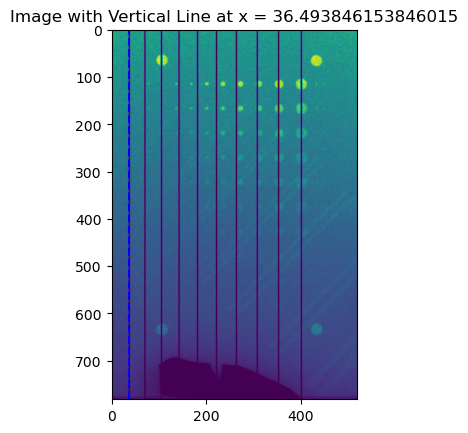

In [70]:
delta_x = []
for i in range(len(circle_centers_filtered)):
    for j in range(i + 1, len(circle_centers_filtered)):
        (x1, y1) = circle_centers_filtered[i]
        (x2, y2) = circle_centers_filtered[j]
        distance_x = abs(x2 - x1)
        if 30 <= distance_x <= 52:  # Adjust the threshold as needed
            delta_x.append(distance_x)

delta_x = list(reversed(sorted(delta_x)))
#delta_x = list(reversed(sorted(np.abs(np.diff(new_pics_maximum_index)))))
print(f"Delta X: {delta_x}")
# Calculate the mean of delta_x to use as a starting step for drawing vertical lines
mean_delta_x = np.min(delta_x) if delta_x else 0

# Linear regression to refine the step size adjustment
if delta_x:
    X = np.arange(len(delta_x)).reshape(-1, 1)
    y = np.array(delta_x)
    model = np.linalg.lstsq(np.hstack([X, np.ones((X.shape[0], 1))]), y, rcond=None)[0]
    slope, intercept = model

# Draw 10 vertical dashed lines starting from the x-coordinate of the first circle
if circle_centers_filtered:
    start_x, start_y = circle_centers_filtered[0]

    for i in range(10):
        if i == 0:
            x = start_x
        else:
            # Using regression to adjust the step dynamically
            step = slope * i *3 + intercept
            print(f"Step: {step}")
            x -= step if step > 0 else mean_delta_x  # Ensure that step does not turn negative

        cv2.line(cropped_image, (int(x), 0), (int(x), cropped_image.shape[0]), (0, 0, 255), 2, lineType=cv2.LINE_AA)

    # Displaying the image with line
    plt.imshow(cropped_image)
    plt.axvline(x, color='b', linestyle='--')  # Blue line for vertical
    plt.title(f"Image with Vertical Line at x = {x}")
    plt.axis('on')
    plt.show()

## Estimation des pas


Distances verticales entre les cercles consécutifs alignés verticalement: [52.0, 52.0, 52.03844732503075, 52.03844732503075, 52.0]


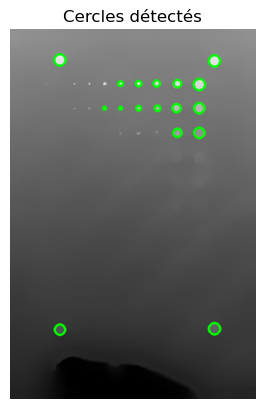

In [71]:
# Trier les cercles par leur coordonnée x
circle_centers_filtered.sort(key=lambda coords: coords[0])

# Filtrer et calculer les distances entre les cercles alignés verticalement
vertical_distances = []
for i in range(len(circle_centers_filtered)-1):
    x1, y1 = circle_centers_filtered[i]
    x2, y2 = circle_centers_filtered[i+1]
    if abs(x1 - x2) <= 30:  # Seulement si les x sont proches à ±10 pixels
        distance = np.linalg.norm(np.array((x1, y1)) - np.array((x2, y2)))
        if (49<=distance<=59):
            vertical_distances.append(distance)

print("Distances verticales entre les cercles consécutifs alignés verticalement:", vertical_distances)

# Convertir en RGB pour l'affichage avec Matplotlib
output_gray_img_rgb = cv2.cvtColor(output_gray_img, cv2.COLOR_BGR2RGB)

# Afficher le résultat
plt.imshow(output_gray_img_rgb)
plt.title('Cercles détectés')
plt.axis('off')
plt.show()

Distances horizontales entre les cercles consécutifs alignés horizontalement: [38.0, 38.0, 44.0, 46.04345773288535, 34.0, 38.0, 40.0, 40.0, 48.0, 46.0]


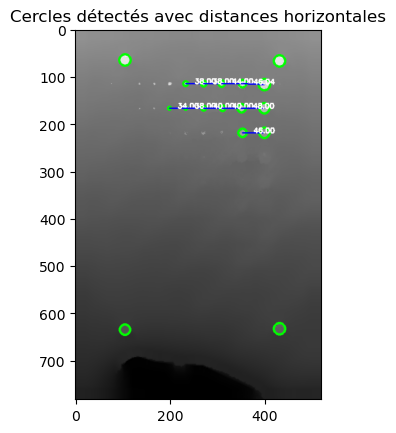

In [72]:
output_gray_img_rgb_hor = output_gray_img
# Trier les cercles par leur coordonnée y
circle_centers_filtered.sort(key=lambda coords: coords[1])

# Filtrer et calculer les distances entre les cercles alignés horizontalement
horizontal_distances = []
for i in range(len(circle_centers_filtered)-1):
    x1, y1 = circle_centers_filtered[i]

    x2, y2 = circle_centers_filtered[i+1]
    if abs(y1 - y2) <= 30:  # Seulement si les y sont proches à ±30 pixels
        distance = np.linalg.norm(np.array((x1, y1)) - np.array((x2, y2)))
        if (30 <= distance <= 51):
            horizontal_distances.append(distance)
            # Dessiner une ligne entre les cercles
            cv2.line(output_gray_img_rgb_hor, (x1, y1), (x2, y2), (255, 0, 0), 2)
            midpoint = ((x1 + x2) // 2, (y1 + y2) // 2)
            # Afficher la distance sur la ligne
            cv2.putText(output_gray_img_rgb_hor, f"{distance:.2f}", midpoint, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

print("Distances horizontales entre les cercles consécutifs alignés horizontalement:", horizontal_distances)

# Convertir en RGB pour l'affichage avec Matplotlib
output_gray_img_rgb_hor_rgb = cv2.cvtColor(output_gray_img_rgb_hor, cv2.COLOR_BGR2RGB)

# Afficher le résultat
plt.imshow(output_gray_img_rgb_hor_rgb)
plt.title('Cercles détectés avec distances horizontales')
plt.axis('on')
plt.show()

In [73]:
for circle in filtered_circles:
    radius = circle[2]
    print(f"Circle radius: {radius}")


Circle radius: 12
Circle radius: 11
Circle radius: 11
Circle radius: 6
Circle radius: 9
Circle radius: 7
Circle radius: 8
Circle radius: 5
Circle radius: 9
Circle radius: 6
Circle radius: 3
Circle radius: 5
Circle radius: 3
